<img src="../Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink service demonstration: Cone Search

### Goal

The goal of this notebook is to demonstrate how to use Fink to match a local list of sources to LSST alerts.

For Rubin, Fink API is updated in real time, even during observation periods in Chile. 
Thus, it is possible to use the examples shown for quick decision making and inspection. 

### Environment set-up

To run this notebook, you need to import the following libraries (already installed in colab):

In [ ]:
import requests
import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

APIURL = 'https://wert038nx.fink-portal.org/'

### Case 1: cone search around one position and error

First set is to identify all the `objects` within your circle of interest

In [22]:
# Get the diaObjectId for the alert(s) within a circle on the sky
r0 = requests.post(
    '{}/api/v1/conesearch'.format(APIURL),
  
    json={
        "ra": "61.9648",
        "dec": "-48.713",
        "radius": "10"
        }
)

The query above will return the last alert per objectId found within your search area.

The second step is to extract the `objectId` themselves and subsequently, the photometric data.

In [48]:
# extract the list of objectIds
mylist = [val["r:diaObjectId"] for val in r0.json()]

You can directly inspect these objects in the portal

In [51]:
for name in mylist:
    print('https://lsst.fink-portal.org/{}'.format(name))

https://lsst.fink-portal.org/313761043604045880
https://lsst.fink-portal.org/170028498820792325


In order to get full light curves for these two objects, you should query the `sources` endpoint

In [54]:
# get full lightcurves for all these alerts
r1 = requests.post(
  '{}/api/v1/sources'.format(APIURL),

  json={
    "diaObjectId":  ", ".join(map(str, mylist)),
      
    # choose which columns you want to transfer: https://lsst.fink-portal.org/schemas
    "columns": "r:diaObjectId,r:midpointMjdTai,r:psfFlux,r:psfFluxErr,r:band",
    "output-format": "json"
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r1.content))

You can now plot the resulting light curves for any of the given objectIds

In [58]:
# get only data for the first object in the list
mask = pdf['r:diaObjectId'] == mylist[0]
obj_lc = pdf[mask]

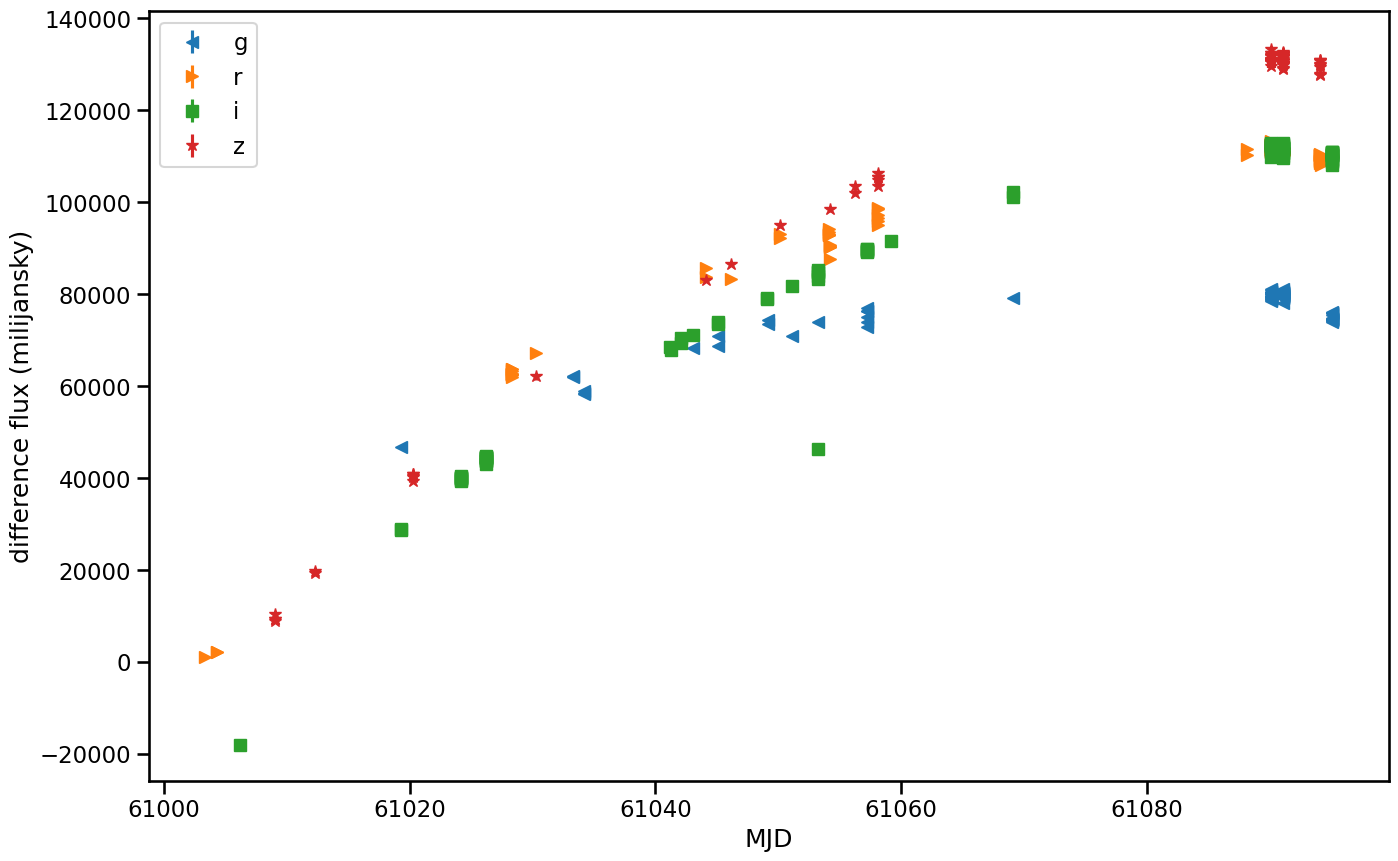

In [70]:
# all lsst bands
all_bands = ['u', 'g', 'r', 'i', 'z', 'y']
symbols = ['o', '<', '>', 's', '*', 'p']

# get unique filters
lc_bands = np.unique(obj_lc['r:band'])

plt.figure(figsize=(16,10))

for i in range(len(all_bands)):
    if all_bands[i] in lc_bands:
        flag = obj_lc['r:band'] == all_bands[i]        # identify one filter at a time
        
        mjd = obj_lc['r:midpointMjdTai'][flag]         # get observation days (MJD)
        flux = obj_lc['r:psfFlux'][flag]               # get difference flux
        fluxerr = obj_lc['r:psfFluxErr'][flag]         # get difference flux error

        plt.errorbar(mjd, flux, yerr=fluxerr, fmt=symbols[i], label=all_bands[i])

plt.xlabel('MJD')
plt.ylabel('difference flux (milijansky)')
plt.legend(loc='upper left')
plt.show()

### Case 2: cone search for a list of positions

In order to cross-match with an entire catalog, you can loop over your sources

In [71]:
# read your catalog
my_cat = pd.read_csv('cone_search_example.csv')

In [75]:
store_objs = []

for item in my_cat:
    
    r = requests.post(
        '{}/api/v1/conesearch'.format(APIURL),
  
        json={
            "ra": str(item['ra']),
            "dec": str(item['dec']),
            "radius": "1.5"
        }
    )

    pdf = pd.read_json(io.BytesIO(r.content))
    store_objs.append(pdf)

data_all = pd.concat(store_objs, ignore_index=True)

TypeError: string indices must be integers, not 'str'

In [77]:
['']

,id,ra,dec
0,SN 2025hlf,185.988527,8.763203
1,SN 2025mbp,151.592582,1.158333
2,SN 2025hlf,185.988523,8.763211
3,SN 2022and,150.027720,3.756888
4,TDE 2018hyz,151.711992,1.692788
5,SN 2025mbp,151.592580,1.158335
6,SN 2025hlf,185.988522,8.763210
7,SN 2025mbp,151.592579,1.158329
8,TDE 2018hyz,151.711991,1.692776
9,SN 2025mbp,151.592579,1.158323
